In [4]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [1]:
!which python

/Users/ziru/miniforge3/envs/gesture_input/bin/python


### Preprocessing

In [5]:
# load data
data_folder = Path("./example_data/1738726494-66512/")

data = {}

for gesture_file in data_folder.glob("*.csv"):
    gesture_name = gesture_file.stem
    data[gesture_name] = pd.read_csv(gesture_file)

# gesture classes
print(data.keys())

dict_keys(['u', 'b', 'r', 'o', 'l'])


In [3]:
# look at data from one gesture
data["u"]

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,timestamp
0,-0.014875,-0.000750,0.123375,0.000183,-0.000137,-0.000229,1.738727e+09
1,-0.014750,-0.000625,0.124000,0.000168,-0.000061,-0.000229,1.738727e+09
2,-0.014500,-0.001250,0.123875,0.000046,0.000244,-0.000534,1.738727e+09
3,-0.014125,-0.004250,0.121000,0.000152,0.000320,-0.000702,1.738727e+09
4,-0.014125,-0.005250,0.120000,0.000168,0.000107,-0.000519,1.738727e+09
...,...,...,...,...,...,...,...
477,-0.001500,-0.037000,0.136750,0.002625,-0.001648,-0.002792,1.738727e+09
478,-0.000625,-0.042375,0.134375,0.001907,-0.001022,-0.002579,1.738727e+09
479,-0.000000,-0.042000,0.131000,0.002030,0.000580,-0.001816,1.738727e+09
480,0.001375,-0.044375,0.123500,0.001587,0.000931,-0.001541,1.738727e+09


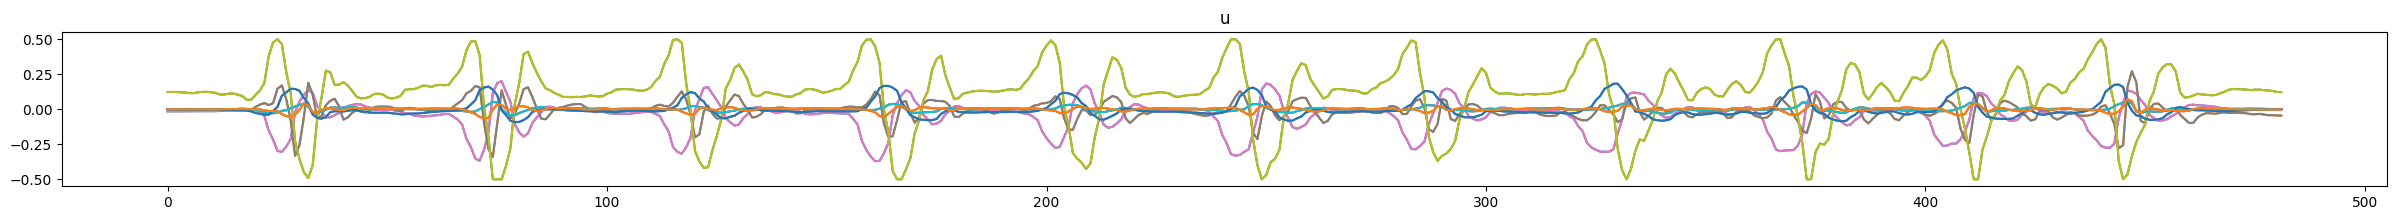

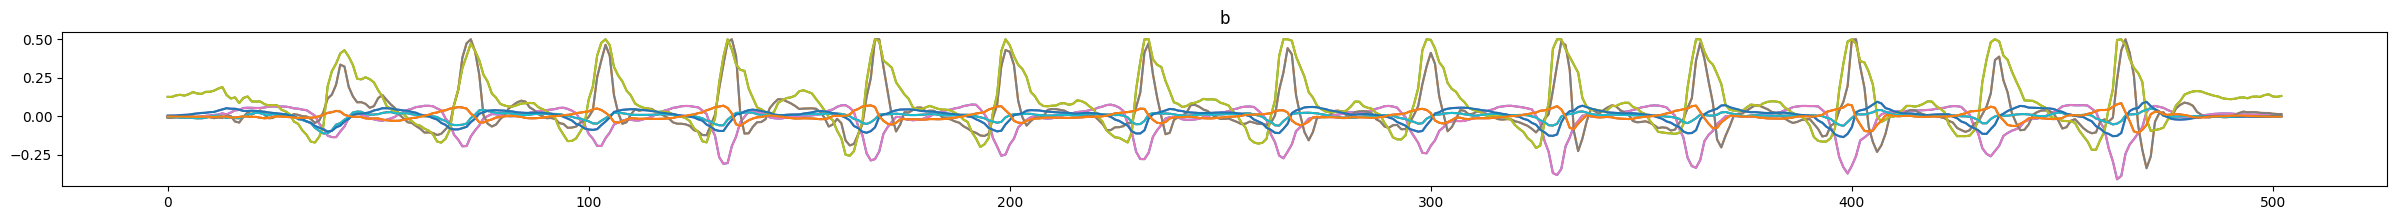

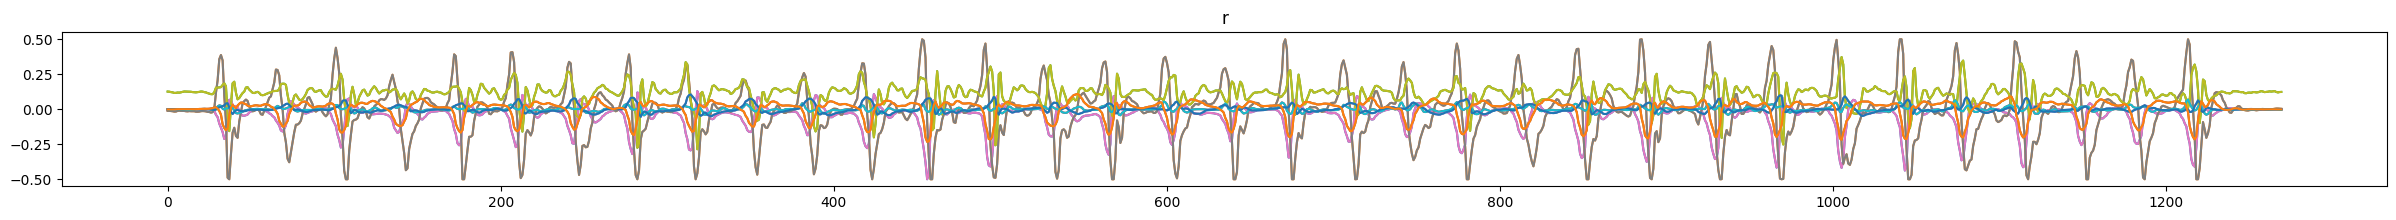

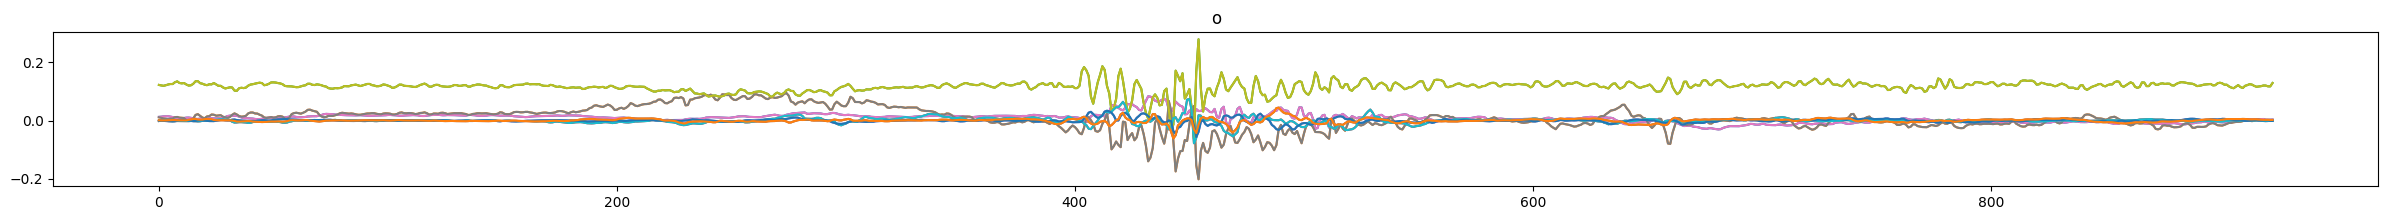

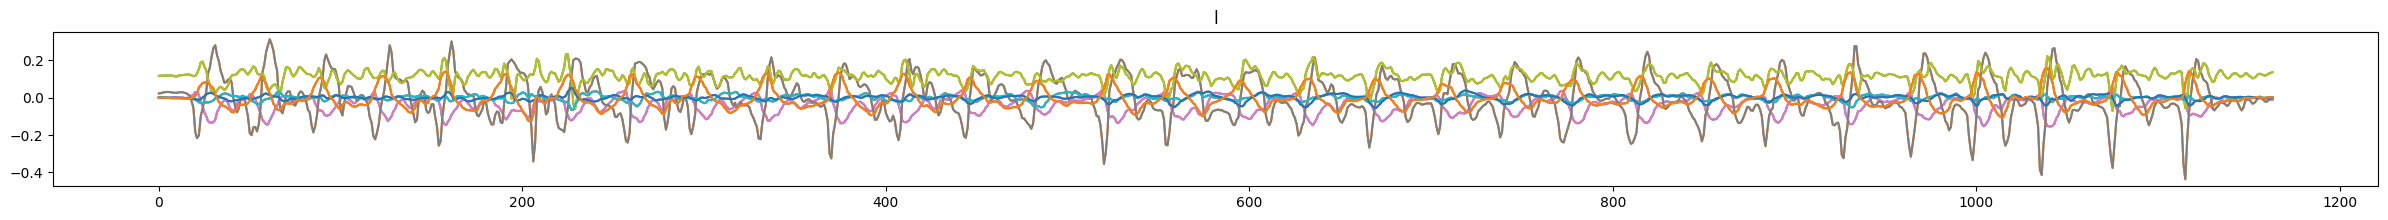

In [6]:
# visualize data from all gestures
for gesture_name, df in data.items():
    plt.figure(figsize=(30, 2))
    plt.title(gesture_name)
    plt.plot(df.values[:, :-1])
    plt.plot(df.values[:, :-1])
    plt.show()




### Training

In [5]:
# create windows of data, window size 50, overlap 49
window_size = 50
X = []
y = []
for gesture_name, df in data.items():
    df_values = df.values[:, :-1]
    label = gesture_name
    for i in range(0, len(df) - window_size, 1):
        X.append(df_values[i:i+window_size].flatten())
        y.append(label)
X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)


(4093, 300) (4093,)


In [6]:
# split data into train and test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3274, 300) (819, 300) (3274,) (819,)


1. 输入层
`Input(shape=(6 * window_size,))`

- 输入形状: (6 * window_size,)，例如 (300,)（假设 window_size=50，6 个 IMU 特征）。

- 作用: 接收展平后的滑动窗口数据（每个窗口包含 50 个时间步 × 6 个传感器维度 = 300 个特征）。

2. 全连接隐藏层
`Dense(64, activation='relu')`

- 神经元数量: 64

- 激活函数: ReLU（修正线性单元），引入非线性，帮助模型学习复杂模式。

- 参数数量: (300 + 1) * 64 = 19,264（300 输入特征，64 个神经元，每个神经元有 1 个偏置项）。

3. 输出层
`Dense(len(data.keys()), activation='softmax')`

- 神经元数量: 等于手势类别数（例如 data.keys() 返回 ['wave', 'circle', 'swipe']，则神经元数为 3）。

- 激活函数: Softmax，将输出转换为概率分布（所有类别的概率之和为 1）。

- 参数数量: (64 + 1) * num_classes（例如 3 类时有 (64+1)*3=195 个参数）。

1. 优化器 (Optimizer)  优化器 (Optimizer)
Adam(learning_rate=3e-4):

自适应学习率的优化算法，结合了动量（Momentum）和 RMSProp 的优点。

learning_rate=3e-4 是初始学习率，较小的值适合精细调整权重。

2. 损失函数 (Loss)
SparseCategoricalCrossentropy():

适用于多分类任务，且标签为整数形式（例如 0, 1, 2）。

如果是 one-hot 编码标签，应使用 CategoricalCrossentropy。

3. 评估指标 (Metrics)
SparseCategoricalAccuracy(name='accuracy'):

计算分类准确率，正确预测的样本比例。

同样适用于整数标签。

模型改进思路
调整网络结构:

增加更多隐藏层（如取消注释的 Dense(64, activation='relu')）。

添加 Dropout 层防止过拟合：

python
keras.layers.Dropout(0.5)
优化超参数:

调整学习率（如 1e-3 或 1e-4）。

使用学习率调度（如 ReduceLROnPlateau）。

数据增强:

对 IMU 数据进行随机扰动（如添加噪声、时间偏移）以增强鲁棒性。

In [ ]:
# train a keras model
import keras

# 设置模型结构
model = keras.Sequential([
    keras.layers.Input(shape=(6 * window_size,)),  # 输入层
    keras.layers.Dense(64, activation='relu'),     # 全连接隐藏层
    keras.layers.Dense(len(data.keys()), activation='softmax')  # 输出层
])

print(model.summary())

# 编译模型
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4), 
    loss=keras.losses.SparseCategoricalCrossentropy(), 
    metrics=[keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
    )

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,589 (76.52 KB)

 Trainable params: 19,589 (76.52 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2721 - loss: 1.5713 - val_accuracy: 0.5528 - val_loss: 1.4243
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5708 - loss: 1.3849 - val_accuracy: 0.5996 - val_loss: 1.2825
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6368 - loss: 1.2386 - val_accuracy: 0.6626 - val_loss: 1.1455
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7022 - loss: 1.0915 - val_accuracy: 0.6748 - val_loss: 1.0109
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7382 - loss: 0.9636 - val_accuracy: 0.7602 - val_loss: 0.8816
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8281 - loss: 0.8422 - val_accuracy: 0.8354 - val_loss: 0.7629
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8778 - loss: 0.7198 - val_accuracy: 0.8923 - val_loss: 0.6544
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9375 - loss: 0.6016 - val_accuracy: 0.9533 - val_loss

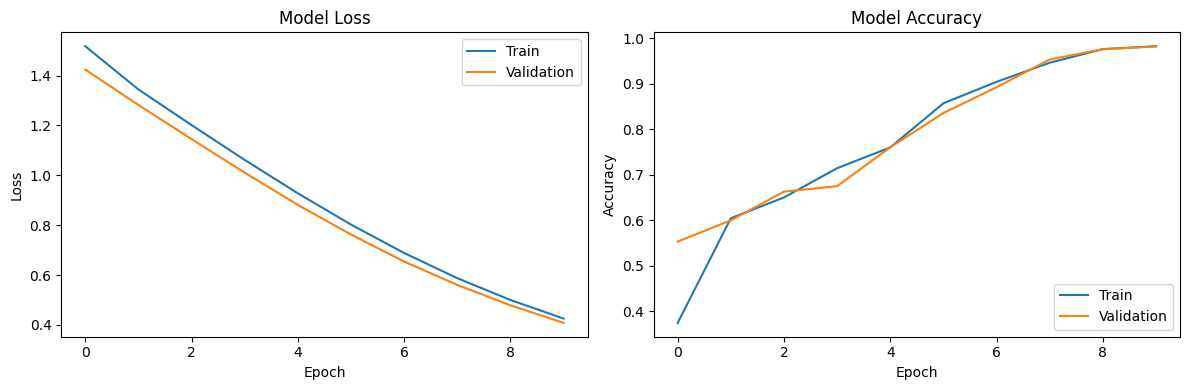

In [ ]:
batch_size = 32
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="./checkpoints/model_at_epoch_{epoch}.keras"),# 每轮保存模型
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),# 验证损失2轮不改善则提前终止训练
]

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.15, #自动保留15%训练数据作为验证集，用于监控模型泛化能力
    callbacks=callbacks,
)
score = model.evaluate(X_test, y_test, verbose=0)# 静默模式评估测试集

# Plot training & validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

### Evaluation

In [9]:
print(f"Test loss: {score[0]:.4f}", f"Test accuracy: {score[1]:.4f}")

Test loss: 0.4121 Test accuracy: 0.9829


In [10]:
# plot losses and accuracy over time

In [11]:
'_'.join(sorted(data.keys()))

'b_l_o_r_u'

### Saving

In [12]:
# save the model
import pickle
import time

# make the model name based on the gesture names
run_timestamp = str(time.time()).replace(".", "-")
model_name = '_'.join(sorted(data.keys())) + "__" + run_timestamp

# make a model directory
model_dir = Path('./models')
model_dir.mkdir(parents=True, exist_ok=True)

with open(model_dir / f'{model_name}.keras', 'wb') as f:
    pickle.dump(model, f)
with open(model_dir / f'label_encoder_{model_name}.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [13]:
model_name

'b_l_o_r_u__1740674278-4041598'

In [14]:
model.predict(X_test[[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


array([[0.04429442, 0.6429971 , 0.03209427, 0.22441898, 0.05619529]],
      dtype=float32)

In [15]:
X_test.shape

(819, 300)